In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

import scipy.special as sc
import pandas as pd
import pymc as pm
import arviz as az
import corner

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

## Kurva Transmisi

In [2]:
df = pd.read_csv('Bessel_R-1.txt', delimiter='\t', header=None)
df.head()

,0,1,2
0,1100.0,NaN,-0.006645
1,1099.5,NaN,-0.008312
2,1099.0,NaN,-0.006417
3,1098.5,NaN,-0.009574
4,1098.0,NaN,-0.006094


In [3]:
data = df[[0, 2]]
data.columns = ['wavelength','percentage']
data = data.dropna(axis=0)

data['percentage'].head()

0   -0.006645
1   -0.008312
2   -0.006417
3   -0.009574
4   -0.006094
Name: percentage, dtype: float64

In [4]:
from scipy.interpolate import interp1d

data_clean = data.dropna(axis=1)
data_clean

,wavelength,percentage
0,1100.0,-0.006645
1,1099.5,-0.008312
2,1099.0,-0.006417
3,1098.5,-0.009574
4,1098.0,-0.006094
...,...,...
1796,202.0,0.000249
1797,201.5,-0.000679
1798,201.0,-0.001274
1799,200.5,-0.000756


In [5]:
data['wavelength'] = data_clean['wavelength'].astype('float') # pastikan kolom wavelength dalam float
data['transmissivity'] = data_clean['percentage']/100.
data.head()

,wavelength,percentage,transmissivity
0,1100.0,-0.006645,-0.000066
1,1099.5,-0.008312,-0.000083
2,1099.0,-0.006417,-0.000064
3,1098.5,-0.009574,-0.000096
4,1098.0,-0.006094,-0.000061


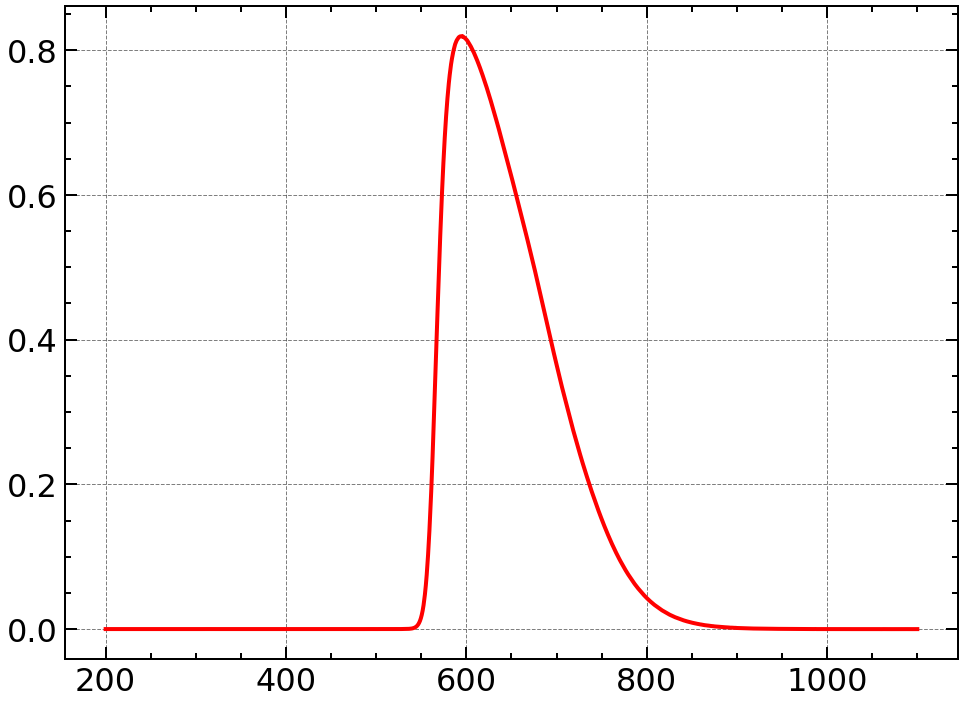

In [6]:
x = data['wavelength']
y = data['transmissivity']
plt.plot(x, y, 'r')

In [7]:
f_interp = interp1d(x, y, kind='cubic')

x_dense = np.linspace(500, 900, 100)
y_dense = f_interp(x_dense)

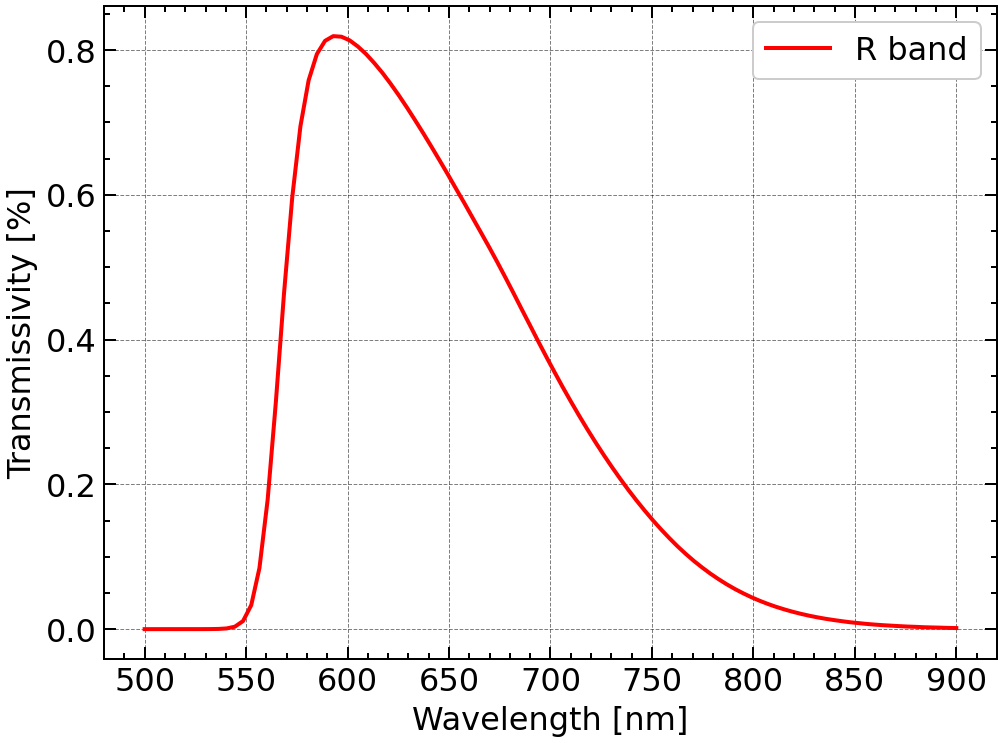

In [8]:
plt.plot(x_dense, y_dense, 'r', label='R band')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmissivity [%]')
plt.legend()
# plt.savefig('r-band.png', dpi=150)

## Kurva respon QHY 174M GPS (tanpa filter)

In [9]:
df2 = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df2.head()

,wavelength,response
0,200.0,0.0
1,210.0,0.0
2,220.0,0.0
3,230.0,0.0
4,240.0,0.0


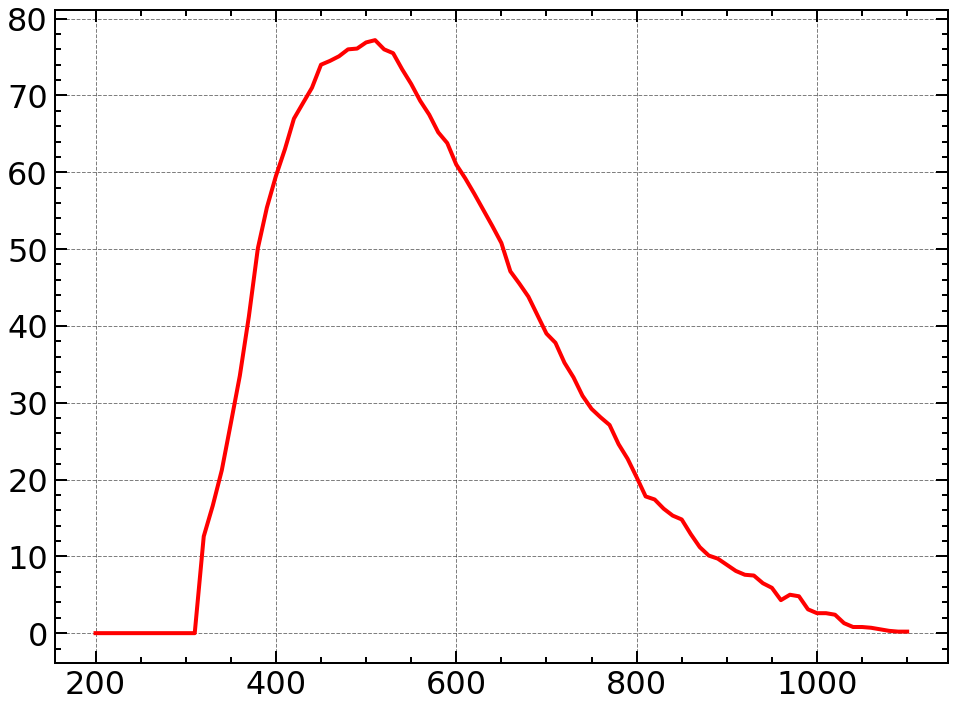

In [10]:
x2 = df2['wavelength']
y2 = df2['response']
plt.plot(x2, y2, 'r')

In [11]:
bandwidth2 = np.arange(330, 1100, 10) # rentang sesuai kurva transmisi

bandwidth2

array([ 330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090])

In [12]:
f_interp2 = interp1d(x2, y2, kind='cubic')

## Kurva Benda Hitam

In [13]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [14]:
def NormData(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

In [15]:
x_axis = np.arange(200, 2000)

x_val = x_axis
y_val = Planck(x_val, 5800)
y_val

array([4.79900306e+13, 4.97875083e+13, 5.16271522e+13, ...,
       4.78208139e+13, 4.77429822e+13, 4.76653057e+13])

In [16]:
den = np.max(y_val)
y_fin = y_val/den

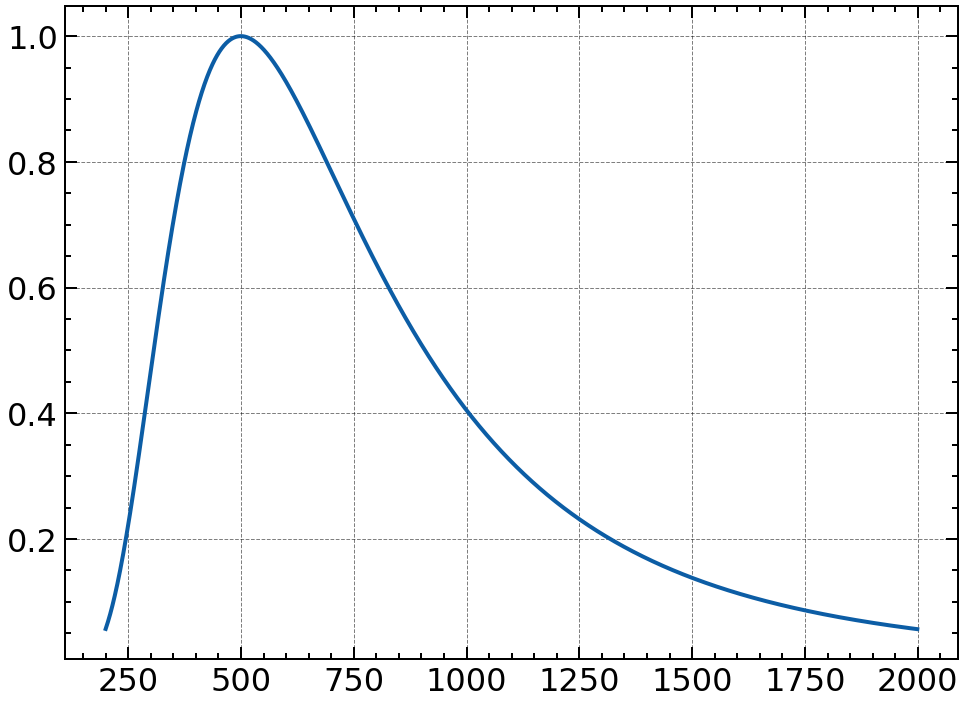

In [17]:
plt.plot(x_axis, y_fin)

In [18]:
bandwidth = np.arange(530, 901, 10) # rentang sesuai kurva transmisi

bandwidth

array([530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780,
       790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900])

In [19]:
y_bandwidth = Planck(bandwidth, 5800)

y_fin_bandwidth = y_bandwidth/den

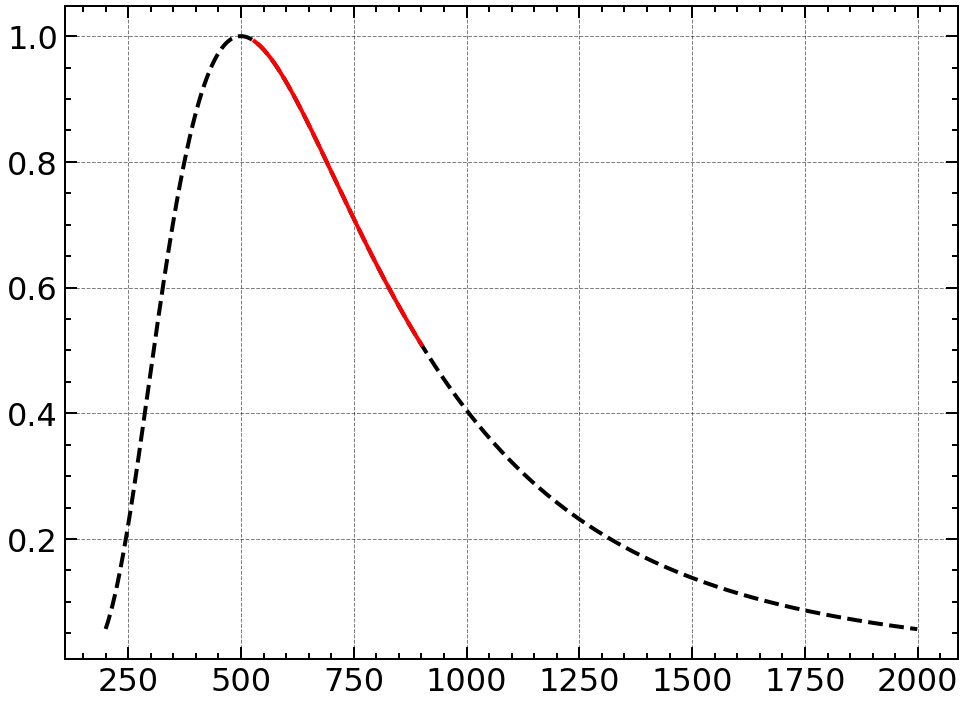

In [20]:
plt.plot(x_axis, y_fin, 'k--')
plt.plot(bandwidth, y_fin_bandwidth, 'r-')
# plt.savefig('planck-5800.png', dpi=150)

Jika menggunakan kurva respon dari QHY 174M GPS tanpa filter, maka kombinasi *bandwidth* dan kurva benda hitam obyek adalah sbb:

In [21]:
x_val2 = x_val
y_val2 = Planck(x_val, 5800)

In [22]:
den2 = np.max(y_val2)
y_fin2 = y_val2/den2

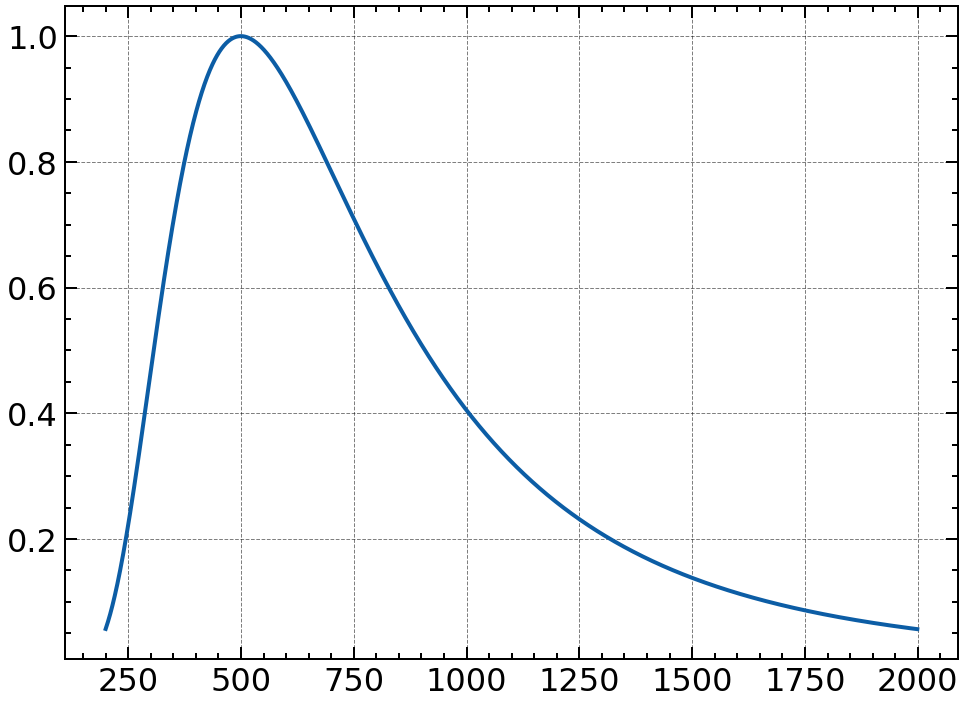

In [23]:
plt.plot(x_val2, y_fin2)

In [24]:
y_bandwidth2 = Planck(bandwidth2, 5800)

In [25]:
y_fin_bandwidth2 = y_bandwidth2/den2

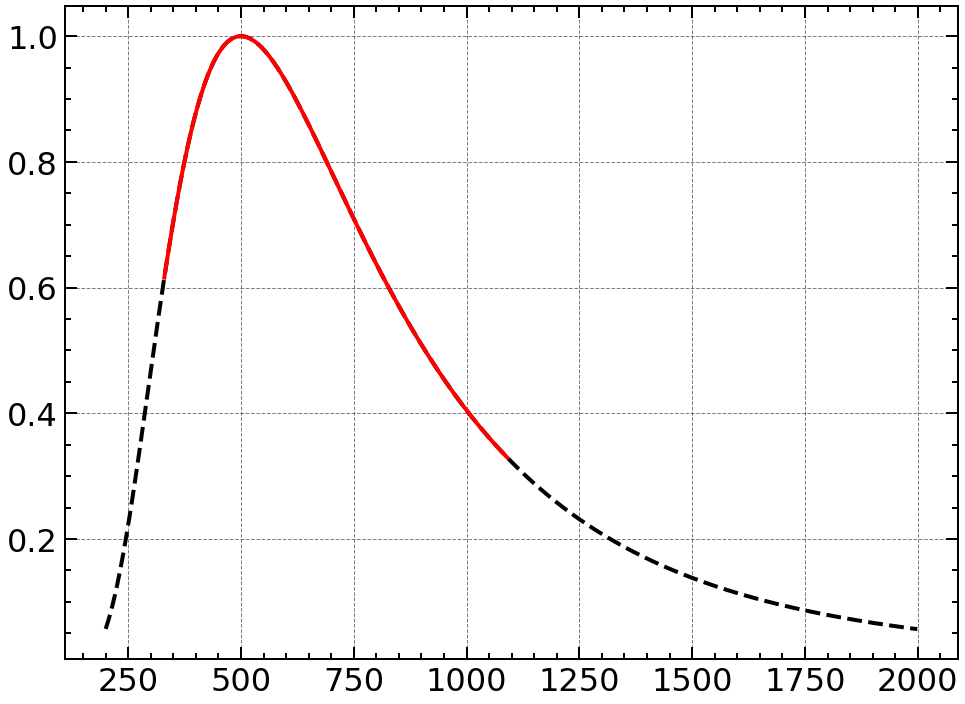

In [26]:
plt.plot(x_val2, y_fin2, 'k--')
plt.plot(bandwidth2, y_fin_bandwidth2, 'r-')

## Data Sintetik

In [27]:
x_data = np.linspace(-100, 100, 500)

In [28]:
d_moon = 374348.01497938664 # satuan km
x0 = 0.
A = 10.
σ_true = 0.15
T = 5800.

In [29]:
def fresnel_polikromatik_norm(x, x0, d):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth2)):
        w = (x - x0) * np.sqrt(2 / (bandwidth2[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp2(bandwidth2[i]) * (Planck(bandwidth2[i], T)/den2) * y
        y0 += y_new
    return y0 / (2*np.mean(y0))

In [30]:
y_data = fresnel_polikromatik_norm(x_data, x0, d_moon)
y_data = np.random.normal(y_data, scale=σ_true)

Text(0, 0.5, 'Intensity')

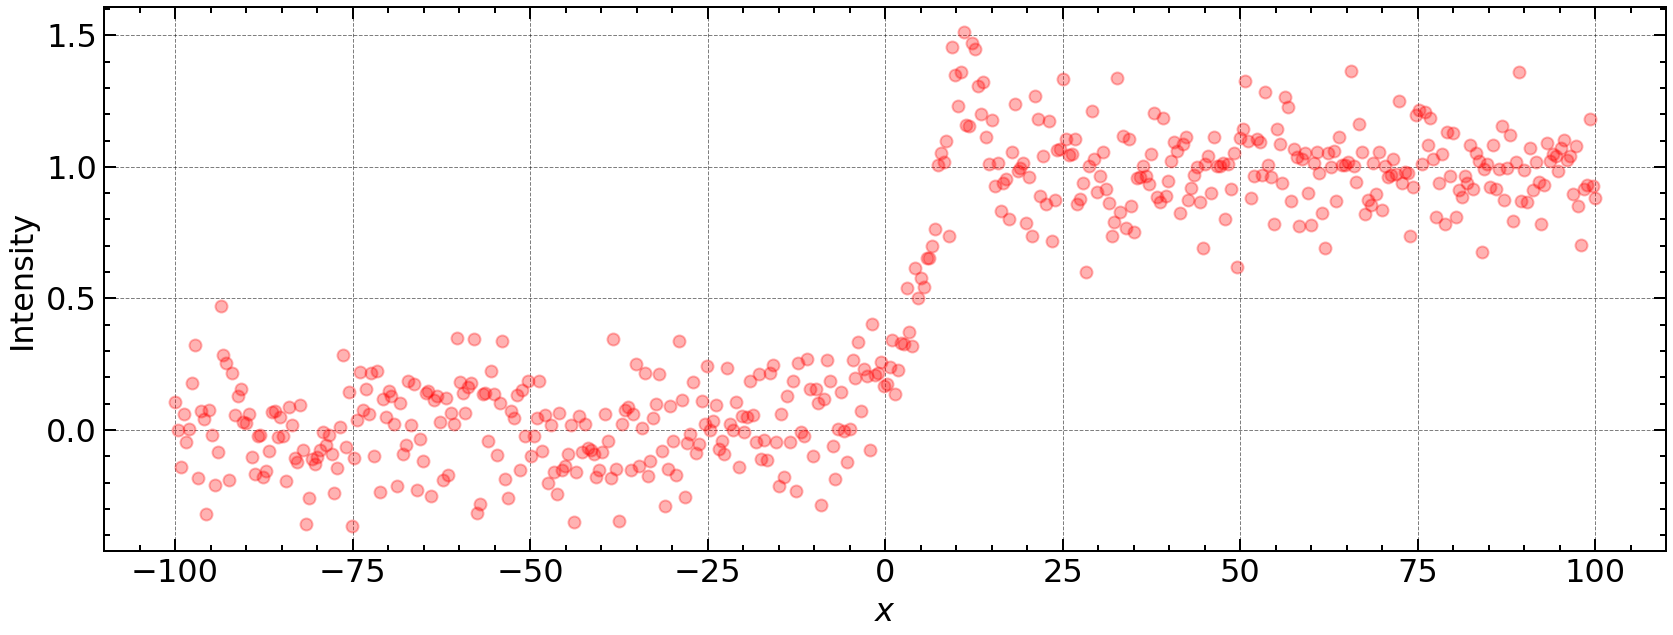

In [31]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_data, marker='o', c='r', alpha=0.3)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')

## Model

In [32]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik_norm(x, x0, d):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth2)):
        w = (x - x0) * np.sqrt(2 / (bandwidth2[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp2(bandwidth2[i]) * (Planck(bandwidth2[i], T)/den2) * y
        y0 += y_new
    return y0 / (2*np.mean(y0))

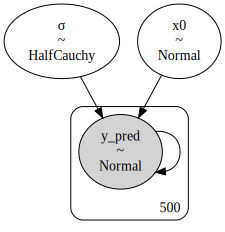

In [33]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik_norm:
    σ = pm.HalfCauchy('σ', beta=20)
    x0 = pm.Normal('x0', mu=0., sigma=10.)
    
    μ = t_fresnel_polikromatik_norm(x_shared, x0, d_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_data)
    
pm.model_to_graphviz(model_polikromatik_norm)

In [35]:
with model_polikromatik_norm:
    # trace = pm.sample(3000, tune=2000, return_inferencedata=True, cores=1)
    idata = pm.sample(3000, cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [σ]
>Slice: [x0]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 421 seconds.


array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

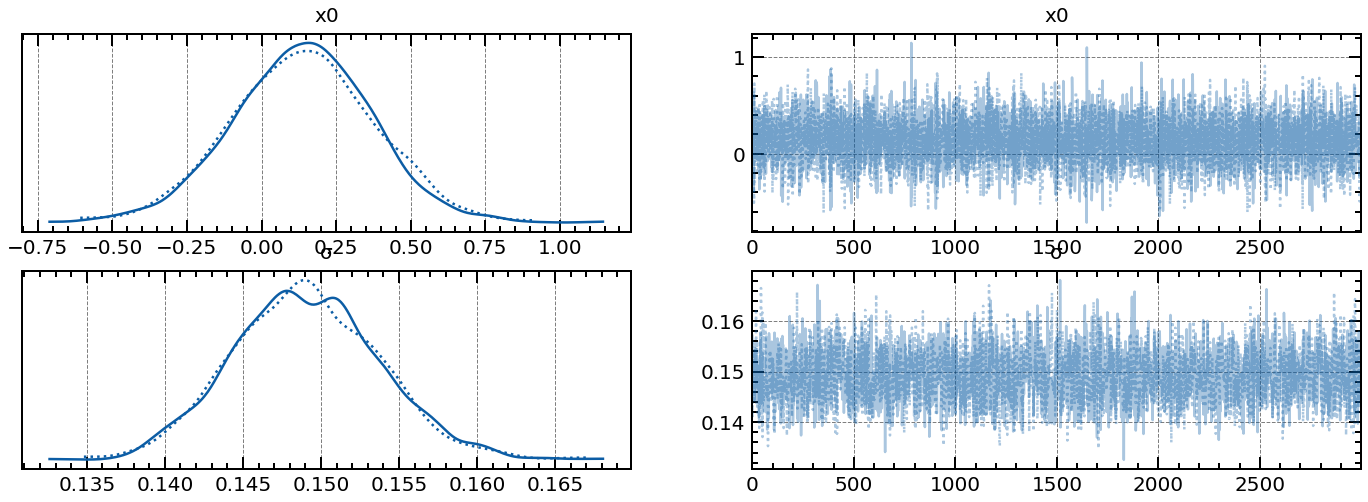

In [36]:
az.plot_trace(idata)

In [37]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.137,0.237,-0.318,0.568,0.003,0.003,6021.0,4221.0,1.0
σ,0.149,0.005,0.140,0.158,0.000,0.000,2468.0,4358.0,1.0


In [38]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik_norm)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [39]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

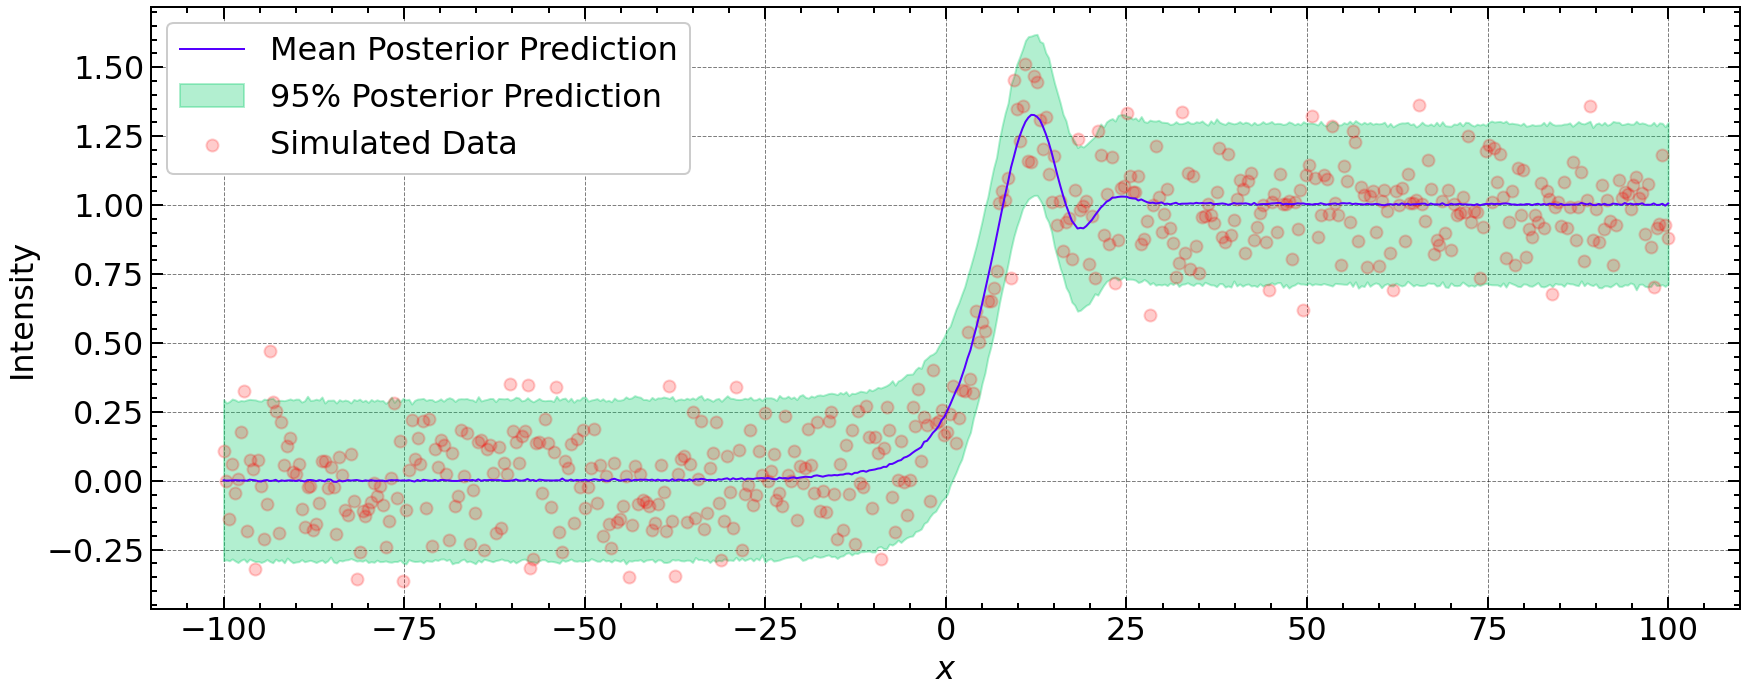

In [40]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.3, color="#00cc66")
plt.scatter(x_data, y_data, c='r', marker='o', alpha=0.2)
# plt.plot(x_data2, y_data2, 'r-', lw=1, alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')

## Normalized Real Data

Ambil contoh data HD 211038

In [41]:
df = pd.read_csv("HD211038-b.csv", sep=',')
df.head()

,FrameNum,timeInfo,signal-track,signal-obj,appsum-track,avgbkg-track,stdbkg-track,nmaskpx-track,maxpx-track,xcentroid-track,ycentroid-track,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1401.0,[17:48:21.8008202],7009.0,-8542.0,563504.0,15040.40,358.28,-37,17552,221.0,273.0,1064096.0,28990.22,2079.95,-37,38704,187.0,128.0
1,1402.0,[17:48:21.8339216],6185.0,-8899.0,562720.0,15041.48,360.31,-37,18016,221.0,273.0,1063248.0,28976.96,2078.54,-37,39904,187.0,128.0
2,1403.0,[17:48:21.8670230],5370.0,-8948.0,561840.0,15039.73,305.92,-37,17104,221.0,273.0,1058752.0,28856.75,2038.57,-37,37968,187.0,128.0
3,1404.0,[17:48:21.9001243],8657.0,-11101.0,566560.0,15078.45,341.18,-37,17696,221.0,273.0,1060384.0,28959.05,2084.82,-37,37552,187.0,128.0
4,1405.0,[17:48:21.9332257],7629.0,-7424.0,563472.0,15022.79,327.23,-37,17232,221.0,273.0,1064016.0,28957.83,2109.99,-37,39152,187.0,128.0


In [42]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

,FrameNum,timeInfo,signal-track,signal-obj,appsum-track,avgbkg-track,stdbkg-track,nmaskpx-track,maxpx-track,xcentroid-track,ycentroid-track,appsum-obj,avgbkg-obj,stdbkg-obj,nmaskpx-obj,maxpx-obj,xcentroid-obj,ycentroid-obj
0,1401.0,2022-06-17 17:48:21.800820,7009.0,-8542.0,563504.0,15040.40,358.28,-37,17552,221.0,273.0,1064096.0,28990.22,2079.95,-37,38704,187.0,128.0
1,1402.0,2022-06-17 17:48:21.833921,6185.0,-8899.0,562720.0,15041.48,360.31,-37,18016,221.0,273.0,1063248.0,28976.96,2078.54,-37,39904,187.0,128.0
2,1403.0,2022-06-17 17:48:21.867023,5370.0,-8948.0,561840.0,15039.73,305.92,-37,17104,221.0,273.0,1058752.0,28856.75,2038.57,-37,37968,187.0,128.0
3,1404.0,2022-06-17 17:48:21.900124,8657.0,-11101.0,566560.0,15078.45,341.18,-37,17696,221.0,273.0,1060384.0,28959.05,2084.82,-37,37552,187.0,128.0
4,1405.0,2022-06-17 17:48:21.933225,7629.0,-7424.0,563472.0,15022.79,327.23,-37,17232,221.0,273.0,1064016.0,28957.83,2109.99,-37,39152,187.0,128.0


In [43]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Time', 'Value']
data.head()

,Frame,Time,Value
0,1401.0,2022-06-17 17:48:21.800820,-8542.0
1,1402.0,2022-06-17 17:48:21.833921,-8899.0
2,1403.0,2022-06-17 17:48:21.867023,-8948.0
3,1404.0,2022-06-17 17:48:21.900124,-11101.0
4,1405.0,2022-06-17 17:48:21.933225,-7424.0


In [44]:
x_data2 = np.array(data['Frame'])
y_data2 = np.array(data['Value'])

Text(0.5, 0, 'Frames')

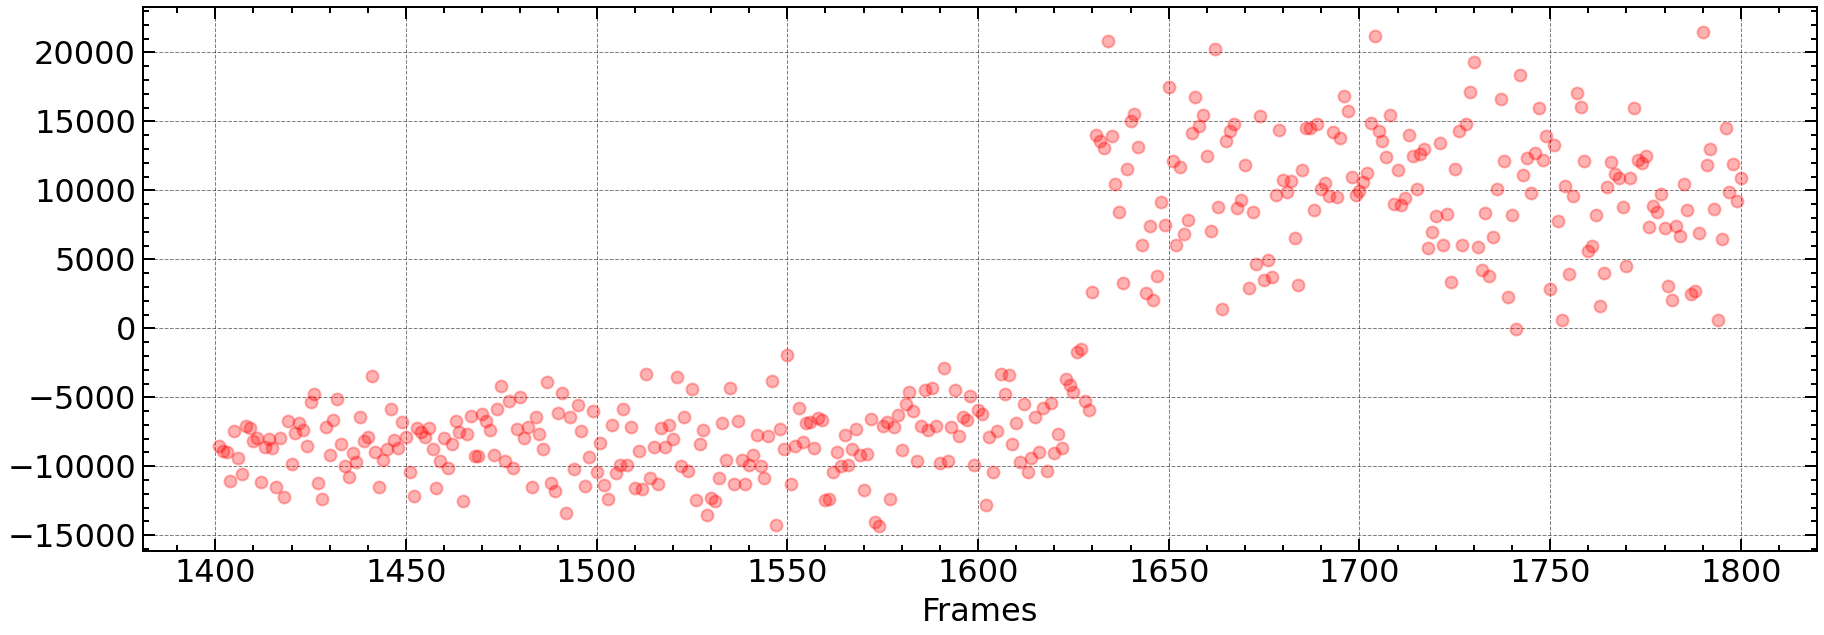

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_data2, y_data2, 'ro', alpha=0.3)
ax.set_xlabel('Frames')

In [46]:
np.mean(y_data2[:100])

y_data2_shift = y_data2 - np.mean(y_data2[:100])

In [47]:
y_norm2 = y_data2_shift / (2*np.mean(y_data2_shift))

Text(0.5, 0, 'Frames')

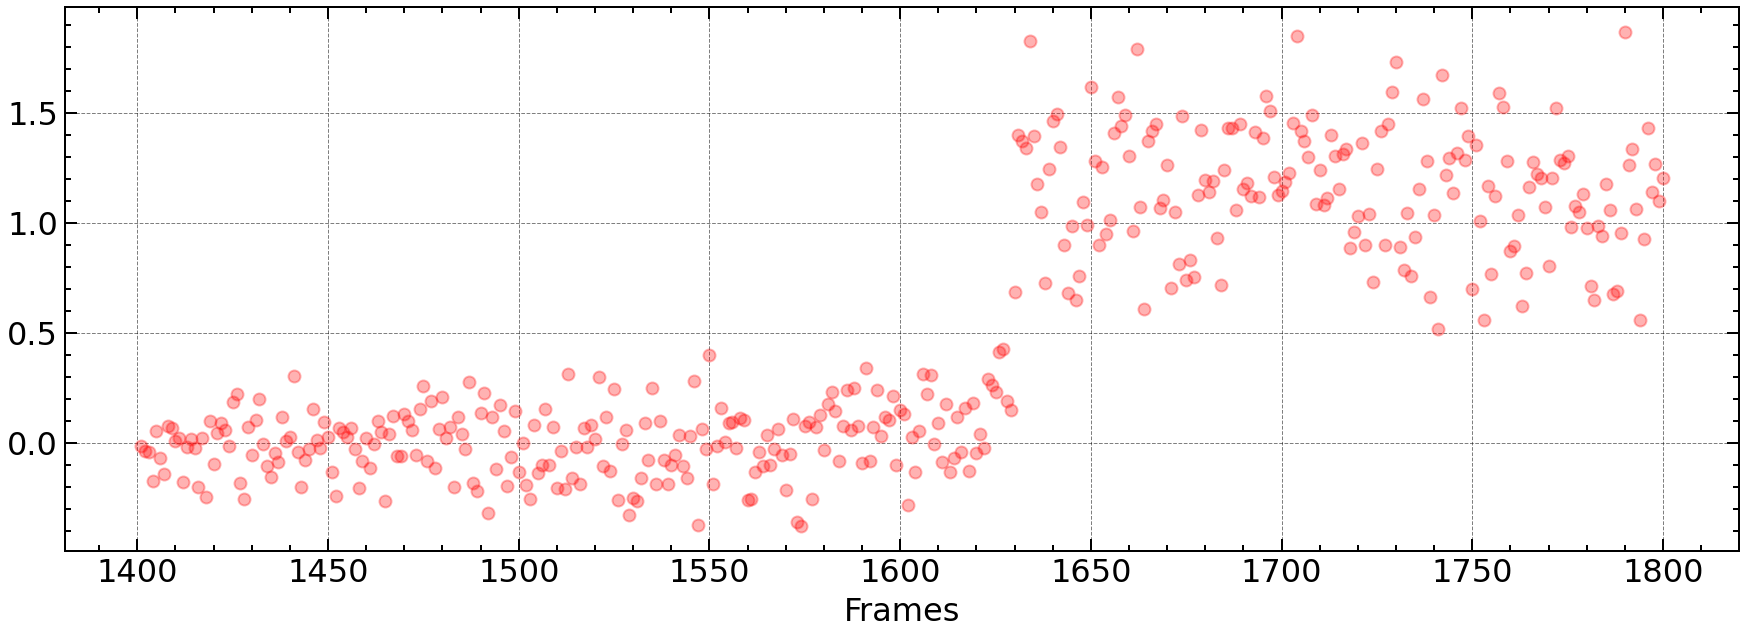

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x_data2, y_norm2, 'ro', alpha=0.3)
ax.set_xlabel('Frames')

In [51]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik_realnorm(x, x0, d):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth2)):
        w = (x - x0) * np.sqrt(2 / (bandwidth2[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp2(bandwidth2[i]) * (Planck(bandwidth2[i], T2)/den2) * y
        y0 += y_new
    return y0 / (2*np.mean(y0))

In [52]:
T2 = 5300 # satuan Kelvin
d_moon2 = 394667.9810011528 # satuan km

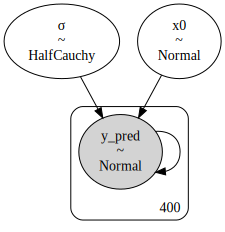

In [53]:
x_shared2 = aesara.shared(x_data2)
d_shared2 = aesara.shared(d_moon2)

with pm.Model() as model_polikromatik_realnorm:
    σ = pm.HalfCauchy('σ', beta=20)
    x0 = pm.Normal('x0', mu=1630., sigma=10.)
    
    μ = t_fresnel_polikromatik_realnorm(x_shared2, x0, d_shared2)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_norm2)
    
pm.model_to_graphviz(model_polikromatik_realnorm)

In [54]:
with model_polikromatik_realnorm:
    idata = pm.sample(3000, cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [σ]
>Slice: [x0]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 424 seconds.


array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

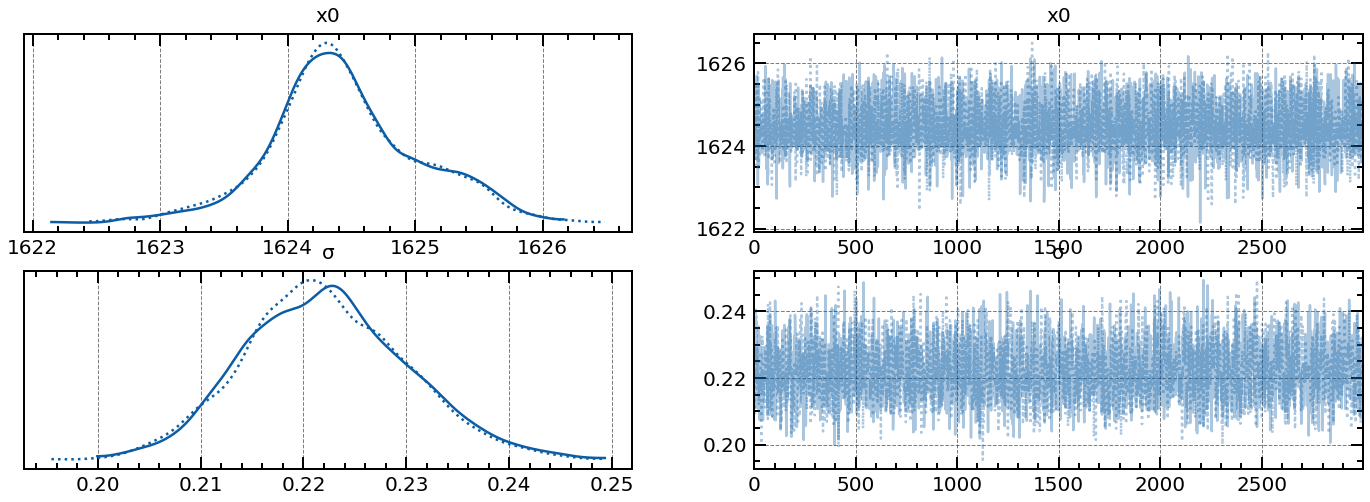

In [55]:
az.plot_trace(idata)

In [56]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1624.444,0.585,1623.438,1625.683,0.008,0.006,5654.0,3429.0,1.0
σ,0.222,0.008,0.208,0.237,0.000,0.000,2689.0,4487.0,1.0


In [57]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik_realnorm)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [58]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

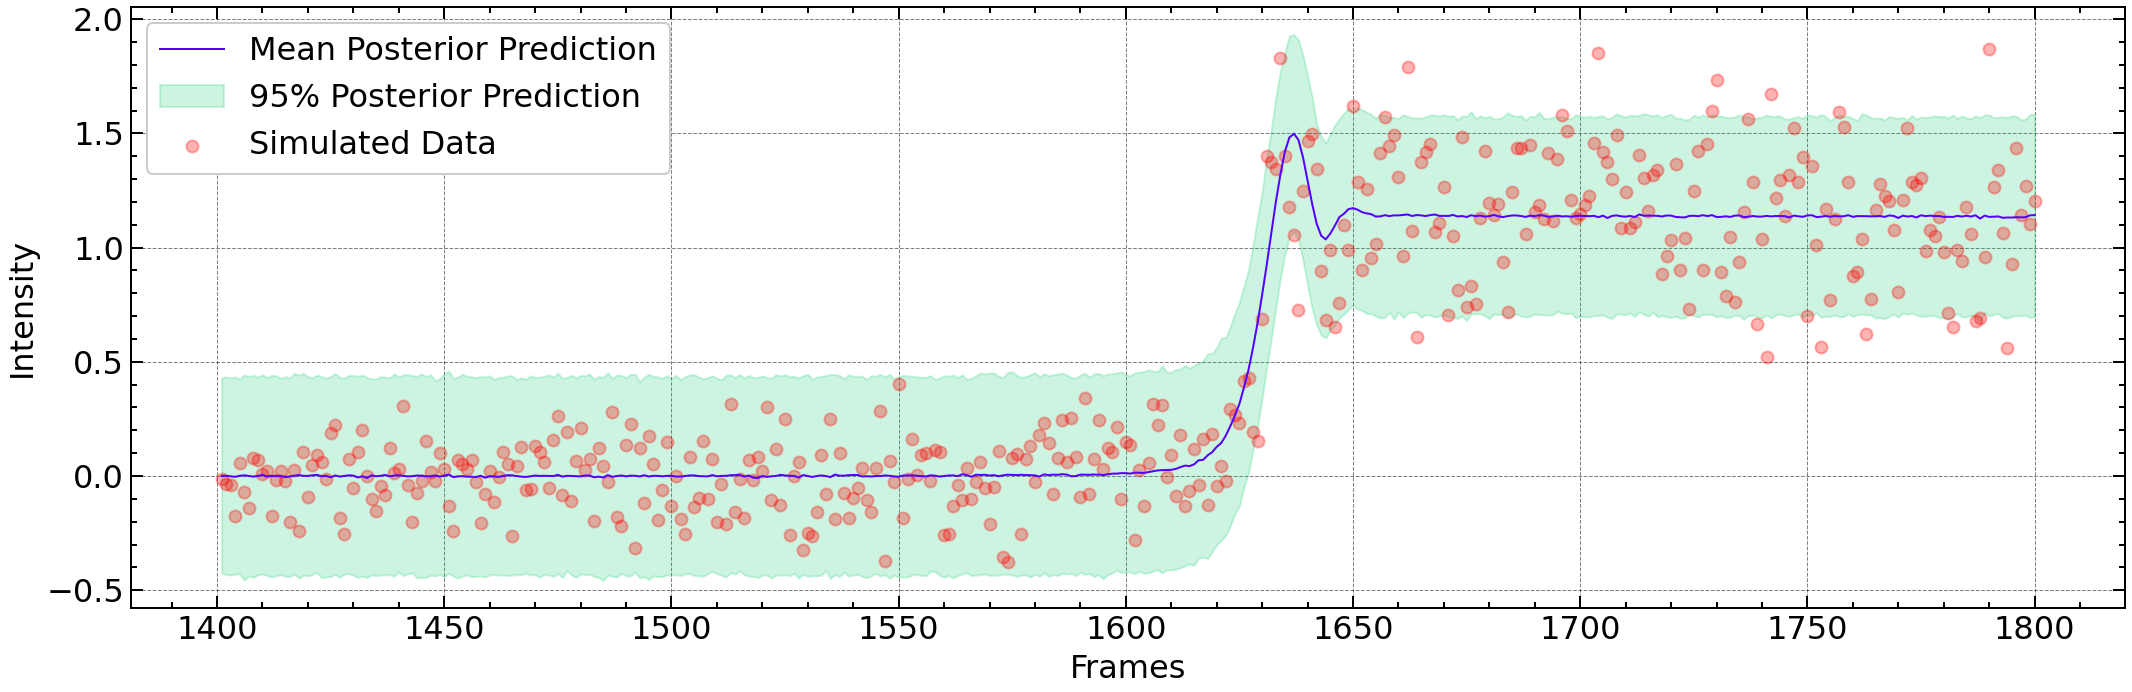

In [59]:
plt.figure(figsize=(15,5))
plt.plot(x_data2, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data2, y_norm2, c='r', marker='o', alpha=0.3)
# plt.plot(x_data2, y_norm2, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')

## Data smoothing

Pada contoh ini, kami menggunakan Savitzky-Golay filter

In [60]:
from scipy.signal import savgol_filter

In [61]:
y_filtered = savgol_filter(y_norm2, 11, 2)

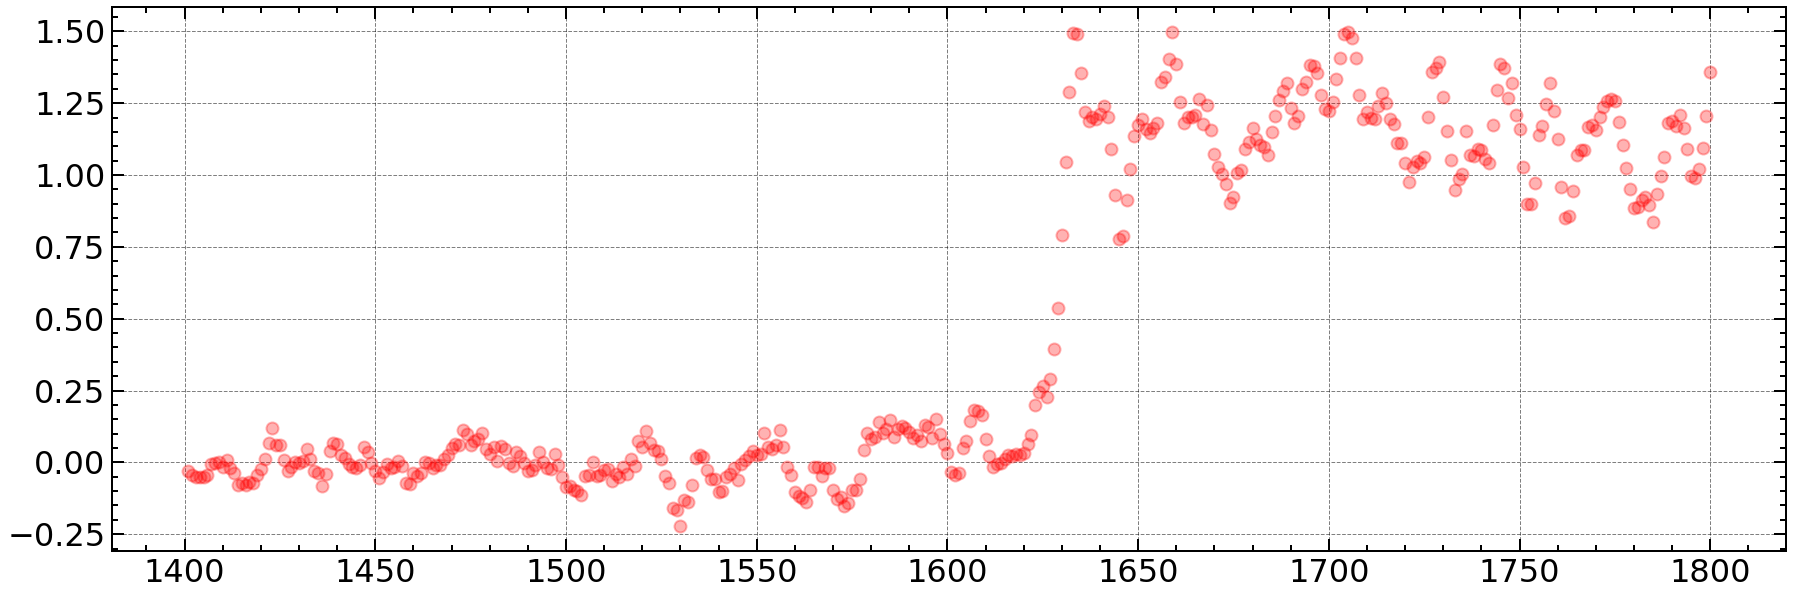

In [62]:
plt.figure(figsize=(15,5))
plt.scatter(x_data2, y_filtered, c='r', marker='o', alpha=0.3)

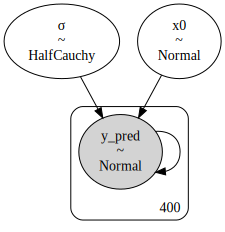

In [63]:
x_shared2 = aesara.shared(x_data2)
d_shared2 = aesara.shared(d_moon2)

with pm.Model() as model_polikromatik_norm_smooth:
    σ = pm.HalfCauchy('σ', beta=20)
    x0 = pm.Normal('x0', mu=1630., sigma=10.)
    
    μ = t_fresnel_polikromatik_realnorm(x_shared2, x0, d_shared2)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_filtered)
    
pm.model_to_graphviz(model_polikromatik_norm_smooth)

In [69]:
with model_polikromatik_norm_smooth:
    idata = pm.sample(3000, cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [σ]
>Slice: [x0]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 414 seconds.


array([[<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

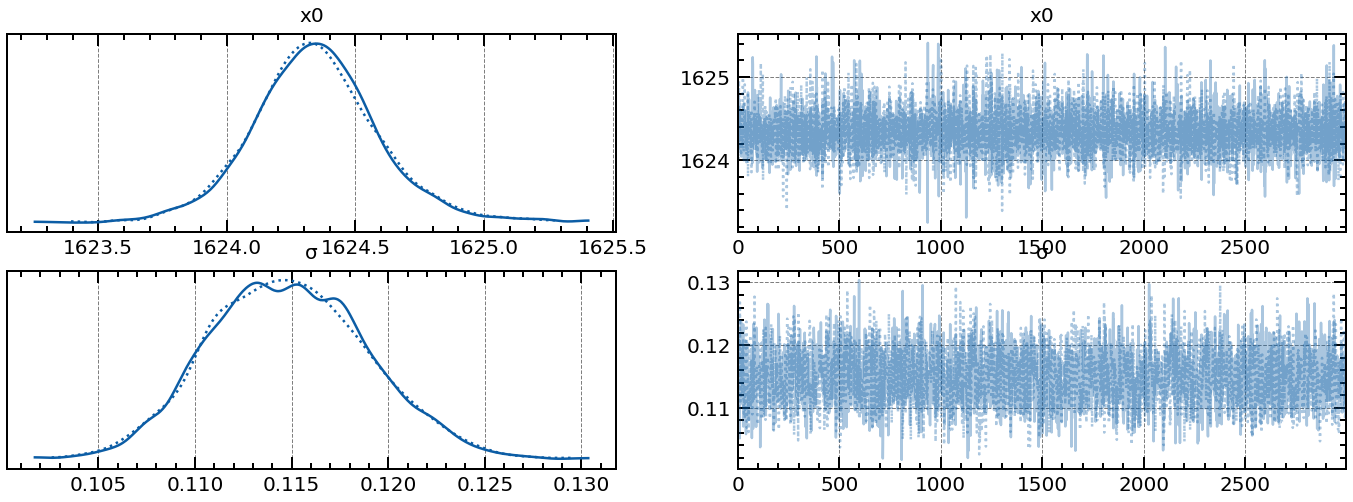

In [70]:
az.plot_trace(idata)

In [71]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1624.346,0.250,1623.868,1624.824,0.003,0.002,6389.0,4257.0,1.0
σ,0.115,0.004,0.107,0.123,0.000,0.000,2404.0,3891.0,1.0


In [72]:
# chain_count =  trace.posterior.stack(sample=("chain", "draw")).σ.values.shape[0]
# y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model_polikromatik_norm_smooth)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [73]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Medianb

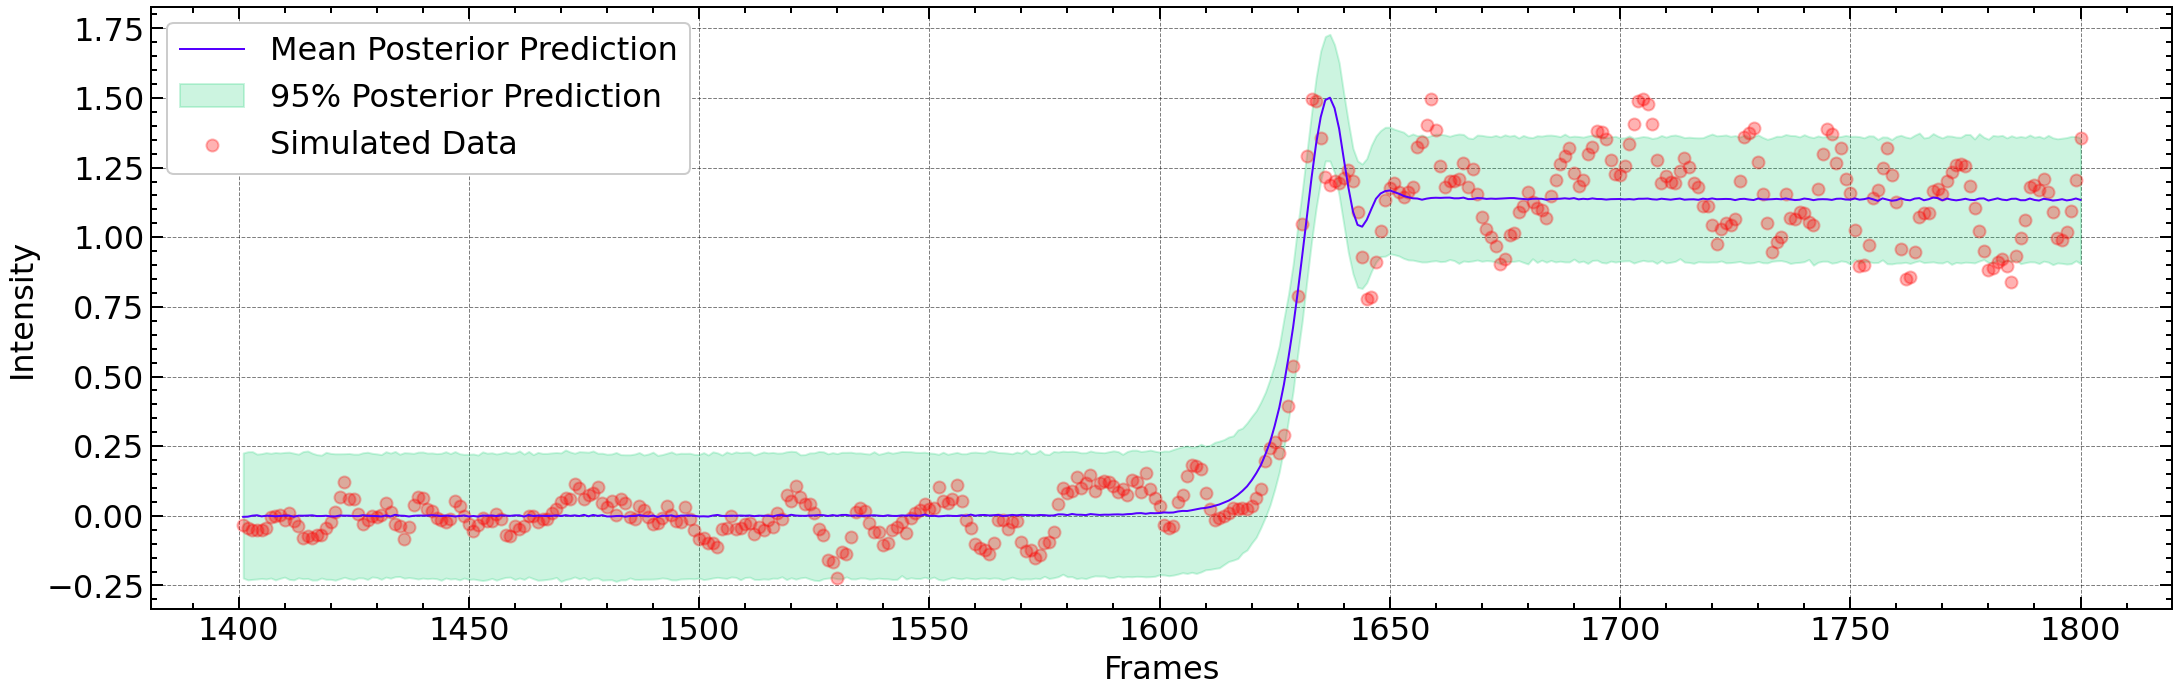

In [74]:
plt.figure(figsize=(15,5))
plt.plot(x_data2, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data2, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data2, y_filtered, c='r', marker='o', alpha=0.3)
# plt.plot(x_data2, y_filtered, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(1850, 2050)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper left')